# **Recommendation System Jester**
Name: Stan Assendelft
<br> Studentnumber: 500748446
<br> Course: System Development for Marketing

# 1| Introduction
Recommendation systems have become a big part of many online platforms, shaping how users discover and interact with content. Among the various types of recommendation systems, collaborative filtering stands out as a widely used and effective approach. This method recommends items to users based on their previous preferences and the behaviour of similar users (Fopa, Gueye, Ndiaye, & Naacke, 2022). 

Algorithms like K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD) are espacially well-known in the field of collaberative filtering, These methods have been popular because they can analyse trends in user-timer interactions to produce personalised suggestions (Yuan, Han, Qian, Xu, & Yan, 2019). 

### 1.1| Reserach Question
The main research question that this notebook aims to investigate is whether KNN and SVD can effectively predict ratings for jokes that a user has never seen before. This question is important because it can help to understand the effectiveness of these algorithms and their potential to improve the user experience of recommendation systems. To answer this question, the accuracy of the predictions made by KNN and SVD will be explored. The following research question and sub-questions arose: <br> 
<br> _Can KNN and SVD effectively predict ratings for jokes that a user has never seen before?_

To address this, the following sub-questions will be explained:
* How accurate are the predictions made by KNN and SVD algorithms for unseen jokes?
* Which algorithm (KNN or SVD) performs better?
* How can the performance of the algorithms be improved?

### 1.2| Importing  Required Libraries

In [ ]:
# Importing all the needed libraries 
# Importing general libraries
import pandas as pd
import numpy as np

# Importing libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importing scipy for calculations
from scipy.sparse import csr_matrix

# Importing sklearn for calculations 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity

# Imporing Suprise package for SVD
from surprise import Dataset, SVD
from surprise import Reader
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from collections import defaultdict

# 2| Explanatory Data Analysis
In this project, the Jester dataset is used, which contains joke ratigns given by users. This chapter focuses on exploring and preparting the dataset to make it suitable for building a recommendations system using K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD). To ensure the data is ready for modeling the dataset will be loaded and cleaned. Throughout this phase, visualisations are used to understand the distributions of users, jokes and ratings. 
### 2.1| Reading Jester Dataset

In [2]:
# Reading and merging the two CSV files
items_df = pd.read_csv(r"E:\DDBM\jester_items.csv")
ratings_df = pd.read_csv(r"E:\DDBM\jester_ratings.csv")

df = pd.merge(items_df, ratings_df, on="jokeId")

In [3]:
df.head()

,jokeId,jokeText,userId,rating
0,5,Q.\tWhat's O. J. Simpson's Internet address? \...,1,0.219
1,5,Q.\tWhat's O. J. Simpson's Internet address? \...,2,-9.688
2,5,Q.\tWhat's O. J. Simpson's Internet address? \...,3,-9.844
3,5,Q.\tWhat's O. J. Simpson's Internet address? \...,4,-5.812
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...,5,6.906


### 2.2| Dataset Understanding

In [4]:
# Checking the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761439 entries, 0 to 1761438
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   jokeId    int64  
 1   jokeText  object 
 2   userId    int64  
 3   rating    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 67.2+ MB


In [5]:
df.describe()

,jokeId,userId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,7.071133e+01,3.272322e+04,1.618602e+00
std,4.600790e+01,1.828011e+04,5.302608e+00
min,5.000000e+00,1.000000e+00,-1.000000e+01
25%,2.100000e+01,1.720200e+04,-2.031000e+00
50%,6.900000e+01,3.480800e+04,2.219000e+00
75%,1.120000e+02,4.730600e+04,5.719000e+00
max,1.500000e+02,6.397800e+04,1.000000e+01


In [6]:
def calculate_statistics(data, item_column="jokeId", user_column="userId"):
    total_ratings = len(data)
    mean_rating = np.mean(data["rating"])
    unique_users = len(np.unique(data[user_column]))
    unique_items = len(np.unique(data[item_column]))
    non_nan_fraction = total_ratings / (unique_users * unique_items)

    print("Total number of ratings:", total_ratings)
    print(f"Mean rating: {mean_rating:.3f}")
    print(f"Number of unique users: {unique_users}")
    print(f"Number of unique items: {unique_items}")
    print(f"Proportion of non-empty ratings: {non_nan_fraction:.3f}")

    return unique_users, unique_items

N, M = calculate_statistics(df)

Total number of ratings: 1761439
Mean rating: 1.619
Number of unique users: 59132
Number of unique items: 140
Proportion of non-empty ratings: 0.213


59132 users have given 140 different jokes ratings. In total the dataset have 1761439 ratings. The sparsity of the dataset is also notable, with a proportion of non-empty ratings at 21.3%, it means that around 78.7% of the possible user–joke combinations are unfilled.

In [ ]:
# Check the min and max values in the dataset
print("Minimum rating:", df["rating"].min())
print("Maximum rating:", df["rating"].max())

Minimum rating: -10.0
Maximum rating: 10.0


In [ ]:
# Count the number of ratings per user
user_rating_counts = df["userId"].value_counts()
# Display the first 10 users with the most ratings
print(user_rating_counts.head(10))

304    140
476    140
477    140
701    140
227    140
442    139
46     136
159    132
410    132
315    131
Name: userId, dtype: int64


In [9]:
# Checking for NaN containing rows
print(sum(df.isnull().any()))

0


In [ ]:
# Count duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


There are no missing values or duplicates in the dataframe.

In [11]:
df = df.sort_values(by=["jokeId", "userId",])
df = df.reset_index(drop=True)

In [12]:
df.head()

,jokeId,jokeText,userId,rating
0,5,Q.\tWhat's O. J. Simpson's Internet address? \...,1,0.219
1,5,Q.\tWhat's O. J. Simpson's Internet address? \...,2,-9.688
2,5,Q.\tWhat's O. J. Simpson's Internet address? \...,3,-9.844
3,5,Q.\tWhat's O. J. Simpson's Internet address? \...,4,-5.812
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...,5,6.906


### 2.3| Data Visualisation

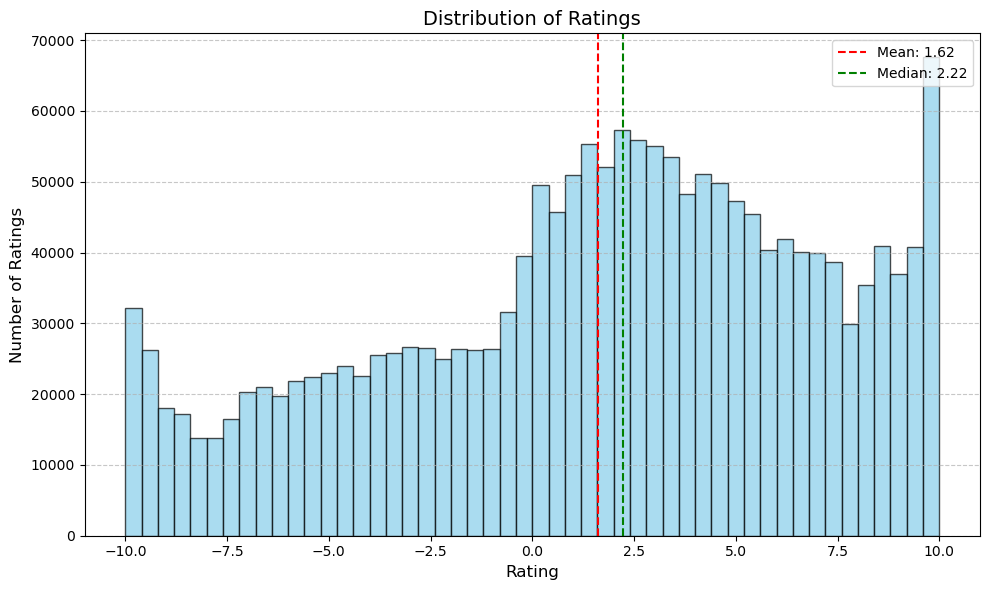

In [13]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Adding mean and median lines
mean_rating = np.mean(df['rating'])
median_rating = np.median(df['rating'])
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_rating:.2f}')
plt.axvline(median_rating, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_rating:.2f}')

# Labels and title
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Distribution of Ratings', fontsize=14)

# Adding grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


The histogram above shows how individual joke ratings are distributed across the full rating scale from -10 to 10. Each bar represents the number of ratings that fall within a specific score range. The mean rating is 1.62 of the dataset.

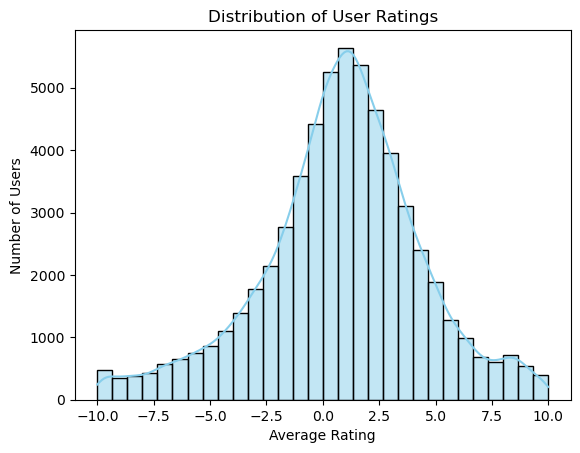

In [ ]:
# Calculating the average rating given by each user
average_user_ratings = df.groupby("userId")["rating"].mean().reset_index()

# Visualise the distribution of user ratings
sns.histplot(average_user_ratings["rating"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of User Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.show()

This histogram shows the distribution of average ratings per user in the dataset. We can see a normal (bell-shaped) distribution, centered around 1.5, which aligns wit the earlier observed mean rating.

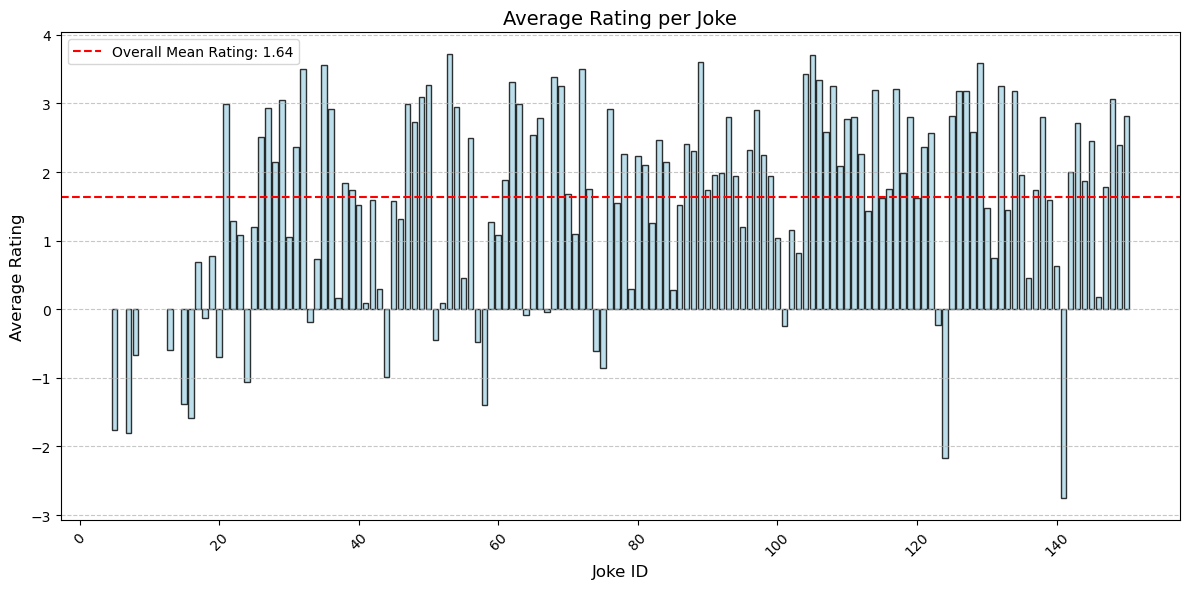

In [ ]:
# Calculating average rating per joke
average_ratings = df.groupby('jokeId')['rating'].mean()

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(average_ratings.index, average_ratings.values, color='lightblue', edgecolor='black', alpha=0.8)
plt.xlabel('Joke ID', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.title('Average Rating per Joke', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.axhline(y=average_ratings.mean(), color='red', linestyle='--', label=f'Overall Mean Rating: {average_ratings.mean():.2f}')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


This bar plot shows the average rating received by each joke, sorted by joke ID on the x-axis. The red dashed line represents the overall average rating across all jokes, which is 1.64.

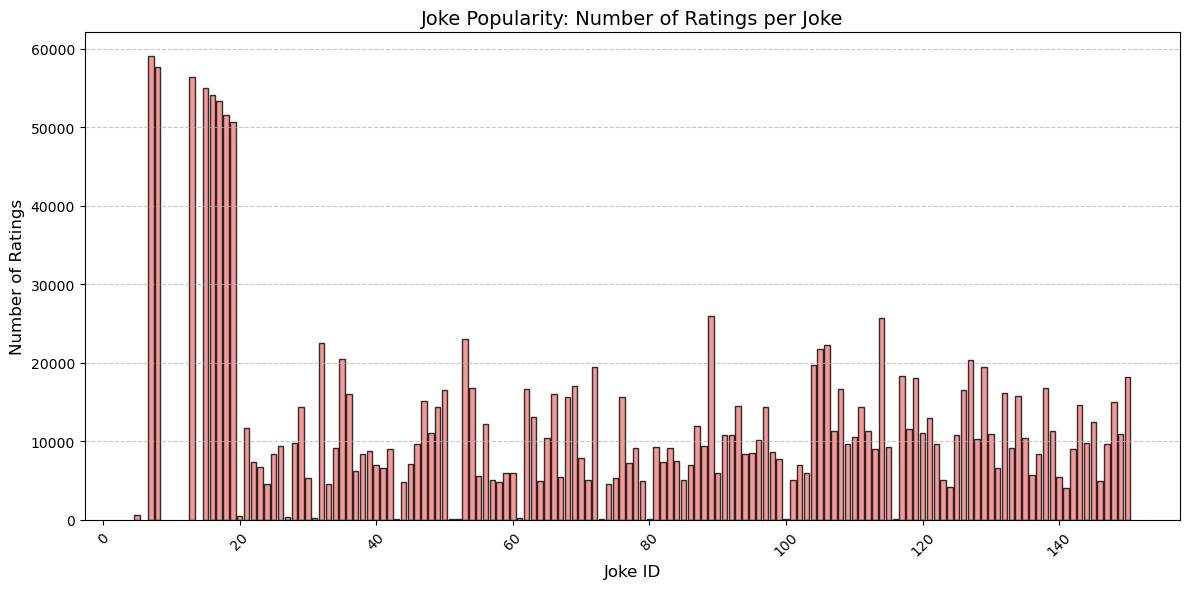

In [ ]:

# Calculating number of ratings per joke
joke_popularity = df['jokeId'].value_counts()

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(joke_popularity.index, joke_popularity.values, color='lightcoral', edgecolor='black', alpha=0.8)
plt.xlabel('Joke ID', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Joke Popularity: Number of Ratings per Joke', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Stan\AppData\Local\Temp\ipykernel_8740\3028576344.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

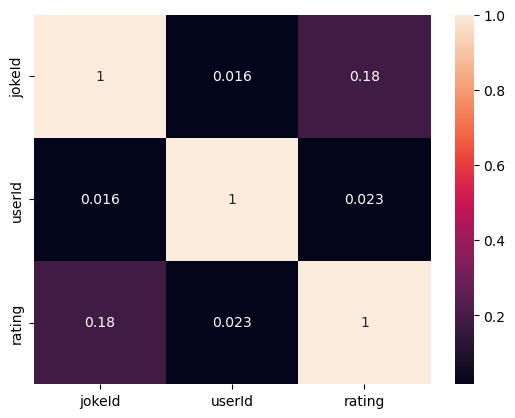

In [16]:
sns.heatmap(df.corr(), annot = True)

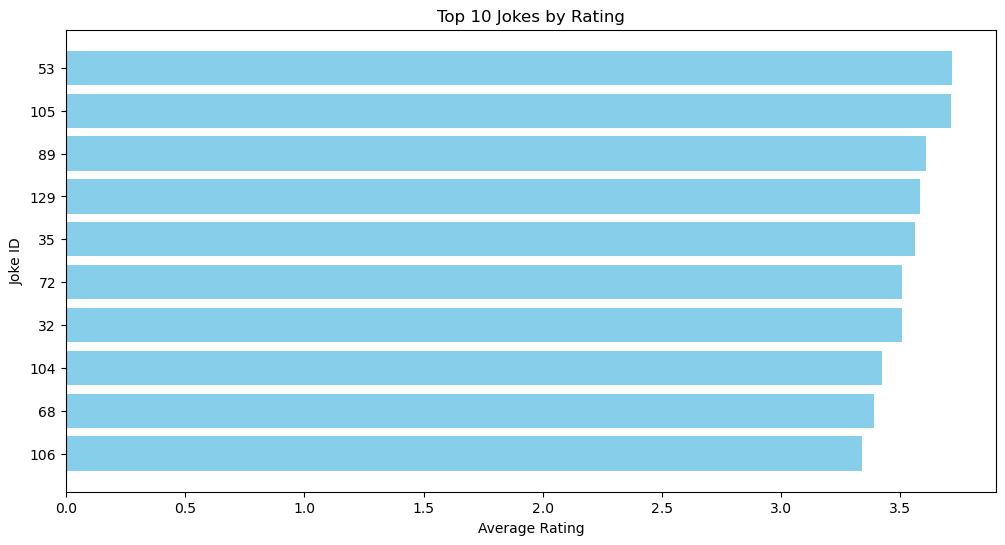

In [ ]:
# Calculating average rating per joke
top_jokes = df.groupby("jokeId")["rating"].mean().reset_index()

# Sort by rating and select top 10
top_jokes = top_jokes.sort_values(by="rating", ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
plt.barh(top_jokes["jokeId"].astype(str), top_jokes["rating"], color="skyblue")
plt.xlabel("Average Rating")
plt.ylabel("Joke ID")
plt.title("Top 10 Jokes by Rating")
plt.gca().invert_yaxis()
plt.show()

Out of the graph we can conclude that joke 53 has the highest average rating. Below is the joke shown.

In [18]:
joke_text = df.loc[df['jokeId'] == 53, 'jokeText'].iloc[0]
print(joke_text)


One Sunday morning William burst into the living room and said,
"Dad! Mom! I have some great news for you! I am getting married
to the most beautiful girl in town. She lives a block away and
her name is Susan."
After dinner, William's dad took him aside. "Son, I have to talk
with you. Your mother and I have been married 30 years.. She's a
wonderful wife but she has never offered much excitement in the
bedroom, so I used to fool around with women a lot. Susan is
actually your half-sister, and I'm afraid you can't marry her."
William was heart-broken. After eight months he eventually
started dating girls again. A year later he came home and very
proudly announced, "Dianne said yes! We're getting married in
June."
Again his father insisted on another private conversation and
broke the sad news. "Dianne is your half-sister too, William. I'm
awfully sorry about this."
William was furious! He finally decided to go to his mother with
the news.
"Dad has done so much harm.. I guess I'm never go

# 3| Model Training and Evaluation
In this chapter, we apply collaborative filtering techniques to build a recommendation system using the Jester dataset. The focus is on evaluating the performance of two popular algorithms: K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD).

To avoid overfitting, the dataset is first splited into training, validation, and testing sets. Two types of implementations were used. A manual KNN and a KNN and SVD with the surprise package. Each model is trained in the training sets and evaluated using the RMSE.

In [ ]:
# Split 80% train, 20% test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Split: 75% of train_data for training, 25% for validation (which is 20% overall)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Split sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")


Training set size: 1056863
Validation set size: 352288
Testing set size: 352288


In [20]:
df_matrix = df.pivot_table(index='userId', columns='jokeId', values='rating').fillna(0)

# Convert each split into user-item matrices
train_matrix = train_data.pivot(index="userId", columns="jokeId", values="rating").fillna(0)
sparse_train_matrix = csr_matrix(train_matrix)

val_matrix = val_data.pivot(index="userId", columns="jokeId", values="rating").fillna(0)
sparse_val_matrix = csr_matrix(val_matrix)

test_matrix = test_data.pivot(index="userId", columns="jokeId", values="rating").fillna(0)
sparse_test_matrix = csr_matrix(test_matrix)


After splitting the dataset, the data is transformed into a user-item matrix format. Each row in the matrix represents a user, and each column represents a joke. The values in the matrix are the corresponding ratings. This format is usefull for collaborative filtering algorithms like manual KNN, which rely on distance-based comparisons between user rating vectors.

In [21]:
df_matrix.head()

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-5.812,-4.500,-4.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.1| Manual K-Nearest Neighbors

In this section a manual implementation of K-Nearest Neighbors (KNN) is performed.

Firstly we identified users with similar rating behavior to the target user. In this case the target user is user ID 10. Using cosine similarity, we measure how similar user 10 rating vector is compared to all other users. The 15 most similar users are extracted.  

In [121]:
#   Parameters
target_user = 10 
num_neighbors = 15 # Number of neighbors

# Compute cosine similarity between target user and all other users
similarities = cosine_similarity(sparse_train_matrix.getrow(target_user), sparse_train_matrix).ravel()

# Find the top similar users (excluding the user itself)
top_similar_users = np.argsort(similarities)[-num_neighbors-1:-1]
top_similar_values = similarities[top_similar_users]

# Store results in a DataFrame
similar_users_df = pd.DataFrame({"User ID": top_similar_users, "Similarity Score": top_similar_values})
similar_users_df = similar_users_df.sort_values(by="Similarity Score", ascending=False)

print(f"Top {num_neighbors} similar users to User {target_user}:")
print(similar_users_df)


Top 15 similar users to User 10:
    User ID  Similarity Score
14    19225          0.733213
13     2645          0.723157
12     3199          0.716134
11    31324          0.709409
10    42240          0.697973
9     22402          0.687141
8       437          0.676853
7      9196          0.654506
6     36058          0.647833
5     17285          0.628938
4     20142          0.627885
3     25834          0.627555
2      7488          0.625524
1      8846          0.625172
0      8559          0.615969


After identifying the top similar users, the code below generate joke recommendations for the target user based on their neighbors' preferences. First, we collect all jokes that the similar users have rated. Then, we exclude jokes the target user has already seen, to avoid suggesting duplicates. For the remaining jokes, we compute the average rating from the similar users, assuming that higher-rated jokes are more likely to be enjoyed.
Finally, the top 10 jokes with the highest average rating are shown with the actual joke text.

In [ ]:
# Get all jokes rated by similar users
similar_user_ids = similar_users_df["User ID"].tolist()

# Retrieve ratings given by similar users
similar_users_jokes = train_data[train_data["userId"].isin(similar_user_ids)]

# Filter out jokes the target user has already rated
target_user_jokes = train_data[train_data["userId"] == target_user]["jokeId"].tolist()
filtered_jokes = similar_users_jokes[~similar_users_jokes["jokeId"].isin(target_user_jokes)]

# Average rating for each joke from similar users
joke_recommendations = filtered_jokes.groupby("jokeId")["rating"].mean().reset_index()

# Sort by highest average rating
top_jokes = joke_recommendations.sort_values(by="rating", ascending=False).head(10)

# Merge with joke text
top_jokes = top_jokes.merge(items_df, on="jokeId")[["jokeId", "rating", "jokeText"]]

print("Top 10 Recommended Jokes for User", target_user)
print(top_jokes)


Top 10 Recommended Jokes for User 10
   jokeId    rating                                           jokeText
0      39  8.844000  What is the difference between men and women:\...
1     138  8.000000  WASHINGTON (Reuters) - A tragic fire on Monday...
2      51  6.875000  Did you hear that Clinton has announced there ...
3     148  6.489333  Recently a teacher, a garbage collector, and a...
4     117  6.144250  A man joins a big corporate empire as a traine...
5     143  6.049800  A preist, a 12-year-old kid, and the smartest ...
6     125  5.875000  An American tourist goes into a restaurant in ...
7     136  5.844000  A man went to apply for a job. After filling o...
8      40  5.750000  How many Irishmen does it take to change a lig...
9      47  5.645833  There was an engineer who had an exceptional g...


Although the KNN process was already performed manually, defining the function below adds structure and flexibility to the workflow. This function allows us to easily retrieve the most similar users for any given target user, without rewriting the similarity logic each time.

In [133]:
def best_neighbours(user_id, train_data, neighbours=15):
    
    if user_id >= train_data.shape[0]:
        print(f"User {user_id} not found in training data.")
        return [], []

    # Compute cosine similarity between target user and all others
    similarity_scores = cosine_similarity(train_data.getrow(user_id), train_data).ravel()

    # Get indices of the most similar users (excluding the target user)
    top_users = np.argsort(similarity_scores)[-neighbours-1:-1]
    top_similarities = similarity_scores[top_users]

    return top_users.tolist(), top_similarities.tolist()

# Similar user finder
target_user = 10
neighbors, similarities = best_neighbours(target_user, sparse_train_matrix, neighbours=15)

print(f"Top {len(neighbors)} similar users to User {target_user}:")
print("User Indices:", neighbors)
print("Similarity Scores:", similarities)


Top 15 similar users to User 10:
User Indices: [8559, 8846, 7488, 25834, 20142, 17285, 36058, 9196, 437, 22402, 42240, 31324, 3199, 2645, 19225]
Similarity Scores: [0.6159690809601794, 0.6251718685344251, 0.6255239224466109, 0.6275551416628784, 0.6278849263665987, 0.6289378765220011, 0.6478334824719635, 0.6545061493777176, 0.6768527063626528, 0.6871413303972846, 0.6979729160242993, 0.7094092779104018, 0.7161338744396897, 0.7231567454616388, 0.733213338732541]


The function returned the 15 users most similar to User 10, based on their joke rating patterns. The user indices represent these similar users in the training data, and the similarity scores show how closely each user's preferences align with User 10.

In [132]:
# Ensure 'jokeId' is not the index in test_data for proper merging
test_ratings = test_data.merge(top_jokes, on="jokeId", how="left", suffixes=("_actual", "_pred"))

# Drop rows where there are no predicted ratings
test_ratings = test_ratings.dropna(subset=["rating_pred"])

# RMSE
rmse = np.sqrt(mean_squared_error(test_ratings["rating_actual"], test_ratings["rating_pred"]))

print(f"KNN Model RMSE: {rmse:.4f}")


KNN Model RMSE: 4.4874


The manual KNN model produced an RMSE of 4.4874, which indicates that on average, the predicted ratings deviate from the actual ratings by approximately 4.49 points. 

#### 3.1.1| Hyperparameter Tunning

To improve the performance of the KNN recommendation model, hyperparameter tuning is performed.

To improve the accuracy of the manual KNN model, we perform a manual hyperparameter tuning process, focusing on the parameter that is about the number of nearest neighbors. The goal is to find the "k" value that results in the lowest RMSE.

In [134]:
# Range of k values to test
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Store RMSE scores for each k
rmse_scores = {}

# Convert sparse validation matrix to dense for RMSE calculation
val_matrix_dense = sparse_val_matrix.toarray()
test_matrix_dense = sparse_test_matrix.toarray()

In [135]:
# Reduce number of users for validation
num_users_sample = 500  
sampled_users = np.random.choice(val_data["userId"].unique(), size=num_users_sample, replace=False)

# Create a mapping from userId to row index in sparse matrix
user_to_index = {user_id: idx for idx, user_id in enumerate(train_matrix.index)}

# Store RMSE scores for each k
rmse_scores = {}

for k in k_values:
    # Train KNN
    knn_model = NearestNeighbors(n_neighbors=max(k_values), metric="cosine", algorithm="brute")
    knn_model.fit(sparse_train_matrix)

    predictions = []
    actual_ratings = []

    for user_id in sampled_users:
        if user_id not in user_to_index:
            continue  # Skip users not found in training matrix

        user_idx = user_to_index[user_id]  # Get row index in sparse matrix

        distances, indices = knn_model.kneighbors(sparse_train_matrix.getrow(user_idx), n_neighbors=max(k_values))
        
        # Select only k nearest neighbors
        similar_users = indices[0][:k]
        neighbor_ratings = (
            train_data[train_data["userId"].isin(similar_users)]
            .groupby("jokeId")["rating"]
            .mean()
        )

        target_user_jokes = val_data[val_data["userId"] == user_id]["jokeId"]
        pred_ratings = neighbor_ratings.reindex(target_user_jokes).fillna(0)

        actual_ratings.extend(val_data[val_data["userId"] == user_id]["rating"].tolist())
        predictions.extend(pred_ratings.tolist())

    # Compute RMSE for this k
    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
    rmse_scores[k] = rmse
    print(f"k={k} > RMSE: {rmse:.4f}")

# Select the best k value
best_k = min(rmse_scores, key=rmse_scores.get)
print(f"Optimal k value: {best_k} with RMSE: {rmse_scores[best_k]:.4f}")


k=5 > RMSE: 6.0540
k=10 > RMSE: 5.9983
k=15 > RMSE: 5.8708
k=20 > RMSE: 5.7794
k=25 > RMSE: 5.6539
k=30 > RMSE: 5.6017
k=35 > RMSE: 5.5007
k=40 > RMSE: 5.4338
k=45 > RMSE: 5.4170
k=50 > RMSE: 5.4256
Optimal k value: 45 with RMSE: 5.4170


For each value between 5 and 50, the model predicted joke ratings for a random sample of 500 users from the validation set. The predicted ratings were then compared to the actual ratings using RMSE as the evaluation metric. The results showed a gradual improvement in RMSE as the number of neighbors increased, indicating that more neighbors helped reduce prediction noise. The optimal value was found at k = 45.

In [136]:
# Train the final KNN model with the best k
final_knn_model = NearestNeighbors(n_neighbors=best_k, metric="cosine", algorithm="brute")
final_knn_model.fit(sparse_train_matrix)

print(f"Final KNN Model trained with k={best_k}")


Final KNN Model trained with k=45


In [137]:
# Generate predictions on test set
predictions = []
actual_ratings = []

for user_id in test_data["userId"].unique():
    if user_id not in user_to_index:
        continue  # Skip users not found in training matrix

    user_idx = user_to_index[user_id]  # Get row index in sparse matrix

    distances, indices = final_knn_model.kneighbors(sparse_train_matrix.getrow(user_idx), n_neighbors=best_k)

    # Get ratings from similar users
    similar_users = indices[0]
    neighbor_ratings = (
        train_data[train_data["userId"].isin(similar_users)]
        .groupby("jokeId")["rating"]
        .mean()
    )

    target_user_jokes = test_data[test_data["userId"] == user_id]["jokeId"]
    pred_ratings = neighbor_ratings.reindex(target_user_jokes).fillna(0)

    actual_ratings.extend(test_data[test_data["userId"] == user_id]["rating"].tolist())
    predictions.extend(pred_ratings.tolist())

# Compute RMSE on test data
final_rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
print(f"Final KNN Model RMSE on Test Data: {final_rmse:.4f}")


Final KNN Model RMSE on Test Data: 5.4801


#### 3.1.1| Recommending jokes

With the optimal value of k identified, the final KNN model was trained using the complete training set. The model was then evaluated on the test set, which had not been seen during training or validation. For each user in the test set, the model dentified the k = 45 most similar users based on cosine similarity.

In [74]:
def recommend_jokes(user_id, model, train_matrix, num_recommendations=10):
   
    if user_id not in user_to_index:
        print("User not found in training data.")
        return None

    user_idx = user_to_index[user_id]

    distances, indices = model.kneighbors(train_matrix.getrow(user_idx), n_neighbors=best_k)

    similar_users = indices[0]
    neighbor_ratings = (
        train_data[train_data["userId"].isin(similar_users)]
        .groupby("jokeId")["rating"]
        .mean()
    )

    # Remove jokes the user has already rated
    user_rated_jokes = train_data[train_data["userId"] == user_id]["jokeId"]
    recommended_jokes = neighbor_ratings.drop(user_rated_jokes, errors="ignore")

    # Sort by highest predicted rating
    recommended_jokes = recommended_jokes.sort_values(ascending=False).head(num_recommendations)

    # Merge with joke text (if available)
    recommended_jokes_df = recommended_jokes.reset_index().merge(items_df, on="jokeId", how="left")

    return recommended_jokes_df

# Example: Get joke recommendations for a specific user
target_user = 10  # Change this to test with different users
top_jokes = recommend_jokes(target_user, final_knn_model, sparse_train_matrix)

# Display recommendations
if top_jokes is not None:
    print(f"\n Recommended Jokes for User {target_user}")
    print(top_jokes.to_string(index=False))



 Recommended Jokes for User 10
 jokeId   rating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 jokeText
      5 6.219000                                                                                                                                              

Finally, the trained KNN model was used to generate personalised joke recommendations for User 10. Using the recommend_jokes function, the model identified jokes that the user had not previously rated but were highly rated by similar users. The output displays the top 10 recommended jokes along with their average predicted rating and the joke text itself.

### 3.2| Surprise Package K-Nearest Neighbors
After implementing the KNN model manually, this chapter explores how to build a recommendation system using the Surprise library. This is a popular Python toolkit designed specifically for building and analyzing recommender systems. In this section, we will apply KNN with different similarity measures, perform hyperparameter tuning, and evaluate the model's predictive performance.

In [81]:
reader = Reader(rating_scale=(-10, 10)) 
data = Dataset.load_from_df(df[['userId', 'jokeId', 'rating']], reader) 
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)


To prepare the data for modeling with the Surprise library, the rating data is first loaded using the Reader and Dataset classes from Surprise. The rating_scale was set to match the Jester dataset's range of -10 to 10. After formatting the data, it was split into a training set and a test set.

In [ ]:
# Train the KNN model with parameters
knn_model = KNNBasic(k=20, sim_options={'name': 'cosine', 'user_based': False}) 
knn_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# Predict ratings for the test set
predictions = knn_model.test(testset)

# RMSE
rmse_score = accuracy.rmse(predictions)


RMSE: 4.1965


After training the KNN model, predictions were generated for the test set, and the model's performance has been evaluated. The resulting RMSE was 4.1965.

#### 3.2.1| Hyperparameter tunning

To improve the performance of the KNN model, hyperparameter tuning was conducted using GridSearchCV from the Surprise library. This process systematically tested various combinations of parameters to identify the configuration that results in the lowest RMSE. The tuning focused on two key elements: the number of neighbors (k), and the similarity measure (cosine or pearson). All models were evaluated using 3-fold cross-validation. After training, the best combination of parameters was selected based on average RMSE.

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'k': [10, 15, 20, 25, 30, 35, 40],  # Trying different numbers of neighbors
    'sim_options': {'name': ['cosine', 'pearson'], 'user_based': [False]}  # Trying both user-based and item-based CF
}

# Run Grid Search
grid_search_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
grid_search_knn.fit(data)

# Print results
print("Best RMSE for KNN:", grid_search_knn.best_score['rmse'])
print("Best Parameters for KNN:", grid_search_knn.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

In [104]:
# KNN Model
knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': False},k=15)
knn_model.fit(trainset)
knn_predictions = knn_model.test(testset)
rmse_score = accuracy.rmse(knn_predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.1905


After computing the similarity matrix and testing all combinations, the best-performing configuration resulted in an RMSE of 4.1905

#### 3.2.2 | Function to generate personalised movie recommendation

To present personalised recommendations, a function was defined to extract the top  predicted jokes for a given user based on the output from the Surprise model.

In [ ]:
def get_top_n_recommendations(predictions, items_df, user_id, n=10):
   
    top_n = defaultdict(list)

    # Store predicted ratings for each user
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort by predicted rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    # Convert to DataFrame with joke texts
    recommendations = pd.DataFrame(
        [(iid, items_df.loc[items_df['jokeId'] == iid, 'jokeText'].values[0] if iid in items_df['jokeId'].values else "Unknown", est)
         for iid, est in top_n.get(user_id, [])[:n]],  
        columns=['Joke ID', 'Joke Text', 'Predicted Rating']
    )

    return recommendations

#### 3.2.3 | Movie recommendation based in KNN Surprise

This call retrieves the top 10 jokes predicted to best match the user’s preferences based on the KNN model's output. The resulting list includes the joke IDs, corresponding joke texts, and their predicted ratings.

In [ ]:
user_id = 10 
recommended_jokes = get_top_n_recommendations(knn_predictions, items_df, user_id)
# Display recommendations
print(f"Top {len(recommended_jokes)} Recommended Jokes for User {user_id}")
print(recommended_jokes.to_string(index=False))

 Top 10 Recommended Jokes for User 10
 Joke ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### 3.3| Singular Value Decomposition with Surprise
This section demonstrates the implementation of a recommendation system using the Singular Value Decomposition (SVD) from the Surprise library. SVD is a matrix factorization technique that uncovers features underlying user-item interactions, making it effective for collaborative filtering tasks. 

The process begins by initializing the dataset using Surprise’s Reader class and loading it with user ratings on jokes. The dataset is then split into training and test sets to evaluate the model's predictive performance.

In [ ]:
# Initialise SVD model
svd_model = SVD()

# Train the model on the training set
svd_model.fit(trainset)

# Predict ratings for the test set
svd_predictions = svd_model.test(testset)

# RMSE
rmse_score = accuracy.rmse(svd_predictions)

RMSE: 4.4684


#### 3.3.1| Hyperparameter Tunning for SVD

SVD model is trained and evaluated using RMSE. To enhance the model’s accuracy, a GridSearchCV is performed across various hyperparameters including the number of latent factors (n_factors), regularization strength (reg_all), and learning rate (lr_all). This cross-validation identifies the combination of parameters that minimizes RMSE.

In [111]:
# Define the parameter grid for tuning
param_grid = {
    'n_factors': [50, 100, 150],  # Number of latent factors
    'reg_all': [0.02, 0.05, 0.1],  # Regularization strength
    'lr_all': [0.002, 0.005, 0.01]  # Learning rate
}

# Run Grid Search
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search_svd.fit(data)

In [112]:
# Get the best hyperparameters
best_params = grid_search_svd.best_params['rmse']

# Train the final SVD model
svd_model = SVD(n_factors=best_params['n_factors'], 
                reg_all=best_params['reg_all'], 
                lr_all=best_params['lr_all'])

# Fit the model on the full training set
svd_model.fit(trainset)

In [ ]:
# Generate predictions on the test set
svd_predictions = svd_model.test(testset)

# RMSE on test data
rmse_score = accuracy.rmse(svd_predictions)

RMSE: 4.1503


After tuning, the SVD model is retrained using the best parameters and applied to the test set, yielding a final RMSE score of 4.1503. Lastly, personalised joke recommendations are generated for a specific user by extracting the top 10 jokes with the highest predicted ratings.

#### 3.3.2| Personalised joke recommendations

In [ ]:
# Get recommendations for user
user_id = 10 

# Get top 10 joke recommendations for the user
svd_recommendations_df = get_top_n_recommendations(svd_predictions, items_df, user_id, n=10)

# Display recommendations
print(f" Top 10 Recommended Jokes for User {user_id} ")
print(svd_recommendations_df.to_string(index=False))


 Top 10 Recommended Jokes for User 10 
 Joke ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# 4|Conclusion

This project explored whether KNN and SVD could effectively predict user ratings for jokes they had not seen and generate recommendations for each user based on similar users there ratings. Both models were implemented, optimezed, and evaluated on their accuracy to understand their strenghts and weaknesses. 

The results show that both KNN and SVD ara capable of generating more or less accurted recommendations. SVD showed slightly better performance in terms of the RMSE. after hyperparameter tuning, SVD achieved an RMSE of 4.1503, compared to KNN's 4.1905 with the surprise library. The manual KNN perfomed the worst with an RMSE of 5.4801.

### 1) How accurate are the predictions made by KNN and SVD algorithms for unseen jokes?
The accuracy of the models was evaluated using RMSE. The differences in RMSE indicate that SVD is slightly better in accuracy. However, all the models still produced RMSE values above 4, showing that the dataset is challenging due to the broad rating scale and diversity in preferences.

### 2) Which algorithm (KNN or SVD) performs better?
Based on the RMSE scores, SVD performed better than KNN. This is expected, as SVD is a matrix factorization technique that captures latent relationships between users and items more effectively, while KNN is limited to surface-level similarities between users or items. KNN was noticeably slower compared to SVD. This difference in performance is due to KNN's reliance on computing similarities across users or items during runtime, which becomes computationally demanding as the dataset grows. In contrast, SVD leverages matrix factorization techniques that allow for faster processing once the model is trained.

### 3) How can the performance of the algorithms be improved?

Several steps contributed to performance improvements:

- Hyperparameter tuning was essential. For example, tuning the number of neighbors in KNN helped reduce the RMSE significantly.
- Data preprocessing, such as filtering for active users and removing missing values, improved the quality of the input data.
- Reducing sparsity and using dimensionality reduction techniques like SVD helped capture deeper patterns in the data.

### **Can KNN and SVD effectively predict ratings for jokes that a user has never seen before?**
Yes, both KNN and SVD can effectively predict ratings for unseen jokes, with varying degrees of accuracy. The models were able to identify patterns in user preferences and generate personalised recommendations. While KNN performed reasonably well, SVD proved to be more effective, achieving a lower RMSE and capturing deeper user-item relationships through matrix factorization. These results suggest that collaborative filtering techniques, especially SVD, are suitable for building joke recommendation systems and can enhance user experience by delivering relevant content even for unrated items.